### Advanced Notebook: Requesting the catalog client
In Terrascope, you can request the catalog client to retrieve the various products that are stored. Below we start with importing the necessary packages for putting the requests, as well as the other more standard packages.


In [3]:
from catalogclient import catalog                         # to interrogate the catalog - this is the one you need to interrogate the Terrascope catalog
import datetime as dt                                     # date and time functions  
import re                                                 # to parse strings
import os                                                 # operating system functions
from xml.etree import ElementTree as ET                   # XML parsing
import rasterio                                           # raster files 
import matplotlib.pyplot as mplot                         # plotting functions
from mpl_toolkits.axes_grid1 import make_axes_locatable   # more plotting functions
import seaborn as sns                                     # extended plotting possibilities wrt matplotlib
import glob                                               # alternative to using os, file/directory searches etc.
import numpy as np                                        # standard Python numpy
import sys                                                # standard Python system package


### Product types

#### Terrascope Sentinel Product types
First, we have a look at the different Sentinel Product Types available in the catalog.

In [4]:
cat=catalog.Catalog()
listOfProducttypes = cat.get_producttypes()
for p in listOfProducttypes:
    print(p)

BioPar_ALB_BHV_V1_Tiles
BioPar_ALB_DHV_V1_Tiles
BioPar_ALBH_V1_Global
BioPar_BA_V1_Tiles
BioPar_DMP_Tiles
BioPar_DMP300_V1_Global
BioPar_FAPAR_V1_Tiles
BioPar_FAPAR_V1_Global
BioPar_FAPAR_V2_Global
BioPar_FCOVER_V1_Tiles
BioPar_FCOVER_V1_Global
BioPar_FCOVER_V2_Global
BioPar_LAI_V1_Tiles
BioPar_LAI_V1_Global
BioPar_LAI_V2_Global
BioPar_NDVI300_V1_Global
BioPar_NDVI300_V1_Global_GTIFF
BioPar_BA300_V1_Global
BioPar_FCOVER300_V1_Global
BioPar_FAPAR300_V1_Global
BioPar_LAI300_V1_Global
BioPar_NDVI_V1_Tiles
BioPar_NDVI_V2_Tiles
BioPar_NDVI_V2_Global
BioPar_SWI
BioPar_SWI10_V3_Global
BioPar_TOCR_Tiles
BioPar_VCI_Tiles
BioPar_VPI_Tiles
BioPar_WB_V1_Tiles
BioPar_WB_V2_Tiles
BioPar_WB_V2_Global
BioPar_WB300_V1_Global
PROBAV_L3_S1_TOC_1KM
PROBAV_L3_S1_TOC_333M
PROBAV_L3_S10_TOC_333M
PROBAV_L3_S5_TOC_100M
PROBAV_L3_S1_TOC_100M
PROBAV_L3_S10_TOC_1KM
PROBAV_L3_S1_TOA_1KM
PROBAV_L3_S1_TOA_333M
PROBAV_L3_S5_TOA_100M
PROBAV_L3_S1_TOA_100M
PROBAV_L1C
PROBAV_L2A_1KM
PROBAV_L2A_333M
PROBAV_L2A_100M
CGS_S

That is a lot of product types. We are only interested in the Sentinel products. These are prefixed with 'CGS', so let's filter them out

In [5]:
listOfTerrascopeSentinelProducttypes = list(filter(lambda f: 'CGS' in f,listOfProducttypes))
listOfTerrascopeSentinelProducttypes

['CGS_S2_FAPAR',
 'CGS_S2_FAPAR_10M',
 'CGS_S2_FAPAR_20M',
 'CGS_S2_NDVI',
 'CGS_S2_NDVI_10M',
 'CGS_S2_LAI',
 'CGS_S2_LAI_10M',
 'CGS_S2_LAI_20M',
 'CGS_S2_FCOVER',
 'CGS_S2_FCOVER_10M',
 'CGS_S2_FCOVER_20M',
 'CGS_S2_RADIOMETRY',
 'CGS_S2_RADIOMETRY_10M',
 'CGS_S2_RADIOMETRY_20M',
 'CGS_S2_RADIOMETRY_60M',
 'CGS_S1_GRD_SIGMA0_L1',
 'CGS_S1_SLC_L1',
 'CGS_S1_GRD_L1']

S1 and S2 relate to the Sentinel satellites; the Sentinel-2 products are also split up per resolution. This is not just a change in spatial resolution:
* the 10 m resolution FAPAR, LAI and FCOVER indices use just the 10m band information 
* the 20 m resolution FAPAR, LAI and FCOVER indices use 10 m <b>and</b> 20 m band information

The S2 products that have no resolution suffix are legacy products that will be discontinued.

#### Looking for Terrascope PROBA-V product types
PROBA-V monitors the Earth's vegetation every day at 100 m (center camera only), 300 m, and 1 km resolution, with daily coverage poleward of 35$^o$ latitude.

These products have a 'PROBAV' prefix

In [6]:
listOfTerrascopePROBAVProducttypes = list(filter(lambda f: 'PROBAV' in f,listOfProducttypes))
listOfTerrascopePROBAVProducttypes

['PROBAV_L3_S1_TOC_1KM',
 'PROBAV_L3_S1_TOC_333M',
 'PROBAV_L3_S10_TOC_333M',
 'PROBAV_L3_S5_TOC_100M',
 'PROBAV_L3_S1_TOC_100M',
 'PROBAV_L3_S10_TOC_1KM',
 'PROBAV_L3_S1_TOA_1KM',
 'PROBAV_L3_S1_TOA_333M',
 'PROBAV_L3_S5_TOA_100M',
 'PROBAV_L3_S1_TOA_100M',
 'PROBAV_L1C',
 'PROBAV_L2A_1KM',
 'PROBAV_L2A_333M',
 'PROBAV_L2A_100M']

* Level 1 data (L1C) are individual Top-of-Atmosphere (TOA) unprojected segments (a part of the orbit from North to South, just covering land areas)
* Level 2 data (L2A) are individual Top-of-Atmosphere projected segments at different resolutions (100 m, 300 m and 1 km)
* Level 3 data (L3) are 
    * composites (collection of segments, covering the Earth)
    * using 1 (S1) , 5 (100 m) or 10 days (300 m and 1 km) of observation
    * Top-of-Atmosphere or Top-of-Canopy (TOC, corrected for the atmospheric reflectance/absorption contribution)


#### Looking for SPOT-VEGETATION product types
The same as for PROBA-V can be done for the SPOT-VGT products. Their prefix is 'SPOTVEGETATION'

In [7]:
listOfTerrascopeSPOTVGTProducttypes = list(filter(lambda f: 'SPOTVEGETATION' in f,listOfProducttypes))
listOfTerrascopeSPOTVGTProducttypes

['SPOTVEGETATION_L3_S1', 'SPOTVEGETATION_L3_S10']

So, here we have only L3 data: composites at 1 km resolution with comprising periods of 1 or 10 days.

### Products

#### Sentinel products
Now we know which product types are available, we can interrogate the catalog to see how many products there are per product type

In [8]:
for pt in listOfTerrascopeSentinelProducttypes:
    listOfTimes = cat.get_times(pt) 
    NumberofAcquisitions = len(listOfTimes)
    
    if NumberofAcquisitions > 0 :
        print('{}: {} products ({} - {})'.format(pt,NumberofAcquisitions,
                                                     str(min(listOfTimes))[8:10] +'/'+ str(min(listOfTimes))[5:7]+'/'+str(min(listOfTimes))[:4],
                                                     str(max(listOfTimes))[8:10] +'/'+ str(max(listOfTimes))[5:7]+'/'+str(max(listOfTimes))[:4]))
    else:
        print('{}: {} products'.format(pt,NumberofAcquisitions))
    


CGS_S2_FAPAR: 3154 products (04/07/2015 - 14/10/2019)
CGS_S2_FAPAR_10M: 3154 products (04/07/2015 - 14/10/2019)
CGS_S2_FAPAR_20M: 3154 products (04/07/2015 - 14/10/2019)
CGS_S2_NDVI: 3114 products (04/07/2015 - 14/10/2019)
CGS_S2_NDVI_10M: 3114 products (04/07/2015 - 14/10/2019)
CGS_S2_LAI: 3152 products (04/07/2015 - 14/10/2019)
CGS_S2_LAI_10M: 3152 products (04/07/2015 - 14/10/2019)
CGS_S2_LAI_20M: 3152 products (04/07/2015 - 14/10/2019)
CGS_S2_FCOVER: 3153 products (04/07/2015 - 14/10/2019)
CGS_S2_FCOVER_10M: 3153 products (04/07/2015 - 14/10/2019)
CGS_S2_FCOVER_20M: 3153 products (04/07/2015 - 14/10/2019)
CGS_S2_RADIOMETRY: 3114 products (04/07/2015 - 14/10/2019)
CGS_S2_RADIOMETRY_10M: 3114 products (04/07/2015 - 14/10/2019)
CGS_S2_RADIOMETRY_20M: 3114 products (04/07/2015 - 14/10/2019)
CGS_S2_RADIOMETRY_60M: 3114 products (04/07/2015 - 14/10/2019)
CGS_S1_GRD_SIGMA0_L1: 4017 products (03/01/2015 - 13/10/2019)
CGS_S1_SLC_L1: 3643 products (03/01/2015 - 13/10/2019)
CGS_S1_GRD_L1: 405

#### PROBA-V products
Similar to the list provided for Sentinel, the number of PROBA-V products is requested.

In [9]:
for pt in listOfTerrascopePROBAVProducttypes:
    listOfTimes = cat.get_times(pt) 
    NumberofAcquisitions = len(listOfTimes)
    
    if NumberofAcquisitions > 0 :
        print('{}: {} products ({} - {})'.format(pt,NumberofAcquisitions,
                                                     str(min(listOfTimes))[8:10] +'/'+ str(min(listOfTimes))[5:7]+'/'+str(min(listOfTimes))[:4],
                                                     str(max(listOfTimes))[8:10] +'/'+ str(max(listOfTimes))[5:7]+'/'+str(max(listOfTimes))[:4]))
    else:
        print('{}: {} products'.format(pt,NumberofAcquisitions))
    

PROBAV_L3_S1_TOC_1KM: 2186 products (15/10/2013 - 13/10/2019)
PROBAV_L3_S1_TOC_333M: 2186 products (15/10/2013 - 13/10/2019)
PROBAV_L3_S10_TOC_333M: 216 products (11/10/2013 - 01/10/2019)
PROBAV_L3_S5_TOC_100M: 402 products (11/03/2014 - 06/10/2019)
PROBAV_L3_S1_TOC_100M: 2038 products (12/03/2014 - 13/10/2019)
PROBAV_L3_S10_TOC_1KM: 216 products (11/10/2013 - 01/10/2019)
PROBAV_L3_S1_TOA_1KM: 2186 products (15/10/2013 - 13/10/2019)
PROBAV_L3_S1_TOA_333M: 2186 products (15/10/2013 - 13/10/2019)
PROBAV_L3_S5_TOA_100M: 402 products (11/03/2014 - 06/10/2019)
PROBAV_L3_S1_TOA_100M: 2038 products (12/03/2014 - 13/10/2019)
PROBAV_L1C: 186724 products (15/10/2013 - 14/10/2019)
PROBAV_L2A_1KM: 180629 products (15/10/2013 - 14/10/2019)
PROBAV_L2A_333M: 180629 products (15/10/2013 - 14/10/2019)
PROBAV_L2A_100M: 59196 products (11/03/2014 - 14/10/2019)


#### SPOT-VEGETATION products

And finally, for SPOT-VEGETATION as well. These are all archive images; the mission stopped delivering data early June 2014

In [10]:
for pt in listOfTerrascopeSPOTVGTProducttypes:
    listOfTimes = cat.get_times(pt) 
    NumberofAcquisitions = len(listOfTimes)
    
    if NumberofAcquisitions > 0 :
        print('{}: {} products ({} - {})'.format(pt,NumberofAcquisitions,
                                                     str(min(listOfTimes))[8:10] +'/'+ str(min(listOfTimes))[5:7]+'/'+str(min(listOfTimes))[:4],
                                                     str(max(listOfTimes))[8:10] +'/'+ str(max(listOfTimes))[5:7]+'/'+str(max(listOfTimes))[:4]))
    else:
        print('{}: {} products'.format(pt,NumberofAcquisitions))

SPOTVEGETATION_L3_S1: 5901 products (01/04/1998 - 02/06/2014)
SPOTVEGETATION_L3_S10: 583 products (01/04/1998 - 01/06/2014)


#### Products in a selected area, within a predefined time window

It's all very well to know that there are many products, but you need to find the ones that are of interest to you.

To narrow down, below we provide a list of Sentinel products for a pre-defined time window over a selected area.
In this case, we want to select the GEOTiff fAPAR data for 1 - 5 July 2018 for the region 51 - 52$^o$N, 4 - 5$^o$E.

In [11]:
productName = 'CGS_S2_FAPAR_10M' # choose any product type in the lists we made earlier
startDate = dt.date(2018,7,1)
endDate = dt.date(2018,7,5)
minLatitude = 51 #in decimal degrees, positive for North
maxLatitude = 52
minLongitude = 4 #in decimal degrees, positive for East
maxLongitude = 5

#get the list of products
listOfProducts = cat.get_products (productName, 
                            fileformat='GEOTIFF', 
                            startdate=startDate, 
                            enddate=endDate, 
                            min_lon=minLongitude, 
                            max_lon=maxLongitude, 
                            min_lat=minLatitude, 
                            max_lat=maxLatitude)
for p in listOfProducts:
    print(p)

CGS_S2_FAPAR_10M_-1_-1_2018-07-02 10:40:21
CGS_S2_FAPAR_10M_-1_-1_2018-07-05 10:54:27
CGS_S2_FAPAR_10M_-1_-1_2018-07-05 10:54:27
CGS_S2_FAPAR_10M_-1_-1_2018-07-02 10:40:21
CGS_S2_FAPAR_10M_-1_-1_2018-07-03 10:59:38
CGS_S2_FAPAR_10M_-1_-1_2018-07-05 10:54:27
CGS_S2_FAPAR_10M_-1_-1_2018-07-02 10:40:21
CGS_S2_FAPAR_10M_-1_-1_2018-07-03 10:59:38
CGS_S2_FAPAR_10M_-1_-1_2018-07-05 10:54:27


This is not very informative, so we'll have to dig deeper.
A product can have a number of bands, and those are stored in files.
While we're at it, let's extract some usefull information as well.

In [12]:
nbands = 0
productList=[]

#loop over products
for p in listOfProducts:
    # as you can see above, the product is described with parts that are separated with underscores, so we split them up
    # productelements is then a list of the parts
    productelements=re.split("_",str(p))  
    # p.bands() returns a list of different bands. You should not take this too literally. For the RADIOMETRY product, the spectral bands are part of this,
    # but there are other items as well. Examples are : cloud and cloud shadow masks.
    nbands=nbands + len(p.bands())
    
    #loop over bands
    for b in p.bands():
        productdetails=[]
        productdetails.append(productelements[2])  # product name
        productdetails.append(productelements[3])  # resolution
        productdetails.append(productelements[-1]) # datetime
        productdetails.append(p.file(b)[5:]) # file path; the first 5 characters are 'file:', and we have no use for them
        # the file path has intesting information as well, when it is about Sentinel-2 data and products
        folders=re.split('/',p.file(b)[5:]) #this contains all subsequent folders + the actual filename
        items=re.split('_',folders[-1:][0]) #this is the filename itself
        
        productdetails.append(items[2]) # UTM tile id
        productdetails.append(items[3]) # file content
        productList.append(productdetails)

#once productList is completed, print the results
print ('Tile  Date       Time     Res Product')
print ('----- ---------- -------- --- -------')
for p in productList:
    print (p[4], p[2], p[1], p[0], p[5])

Tile  Date       Time     Res Product
----- ---------- -------- --- -------
31UFT 2018-07-02 10:40:21 10M FAPAR SHADOWMASK
31UFT 2018-07-02 10:40:21 10M FAPAR SCENECLASSIFICATION
31UFT 2018-07-02 10:40:21 10M FAPAR CLOUDMASK
31UFT 2018-07-02 10:40:21 10M FAPAR FAPAR
31UET 2018-07-05 10:54:27 10M FAPAR SHADOWMASK
31UET 2018-07-05 10:54:27 10M FAPAR CLOUDMASK
31UET 2018-07-05 10:54:27 10M FAPAR SCENECLASSIFICATION
31UET 2018-07-05 10:54:27 10M FAPAR FAPAR
31UFS 2018-07-05 10:54:27 10M FAPAR FAPAR
31UFS 2018-07-05 10:54:27 10M FAPAR CLOUDMASK
31UFS 2018-07-05 10:54:27 10M FAPAR SHADOWMASK
31UFS 2018-07-05 10:54:27 10M FAPAR SCENECLASSIFICATION
31UES 2018-07-02 10:40:21 10M FAPAR CLOUDMASK
31UES 2018-07-02 10:40:21 10M FAPAR SCENECLASSIFICATION
31UES 2018-07-02 10:40:21 10M FAPAR SHADOWMASK
31UES 2018-07-02 10:40:21 10M FAPAR FAPAR
31UES 2018-07-03 10:59:38 10M FAPAR SCENECLASSIFICATION
31UES 2018-07-03 10:59:38 10M FAPAR FAPAR
31UES 2018-07-03 10:59:38 10M FAPAR SHADOWMASK
31UES 2018-07-0

So, we have following 'bands':
* FAPAR - the actual image file with the FAPAR value
* SCENECLASSIFICATION - an automatic classification into about 10 classes (see https://earth.esa.int/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm for more info)
* CLOUDMASK - a binary file indicating the presence of cloud per pixel
* SHADOWMASK - a binary file indicating the presence of cloud shadow per pixel


To filter out the proper FAPAR files:

In [13]:
FAPARFiles = list(filter(lambda f: 'FAPAR' in f[5],productList))
for f in FAPARFiles:
    print(f[3]) #this is where the filename is

/data/MTDA/CGS_S2/CGS_S2_FAPAR/2018/07/02/S2B_20180702T104019Z_31UFT_CGS_V102_000/S2B_20180702T104019Z_31UFT_FAPAR_V102/10M/S2B_20180702T104019Z_31UFT_FAPAR_10M_V102.tif
/data/MTDA/CGS_S2/CGS_S2_FAPAR/2018/07/05/S2B_20180705T105029Z_31UET_CGS_V102_000/S2B_20180705T105029Z_31UET_FAPAR_V102/10M/S2B_20180705T105029Z_31UET_FAPAR_10M_V102.tif
/data/MTDA/CGS_S2/CGS_S2_FAPAR/2018/07/05/S2B_20180705T105029Z_31UFS_CGS_V102_000/S2B_20180705T105029Z_31UFS_FAPAR_V102/10M/S2B_20180705T105029Z_31UFS_FAPAR_10M_V102.tif
/data/MTDA/CGS_S2/CGS_S2_FAPAR/2018/07/02/S2B_20180702T104019Z_31UES_CGS_V102_000/S2B_20180702T104019Z_31UES_FAPAR_V102/10M/S2B_20180702T104019Z_31UES_FAPAR_10M_V102.tif
/data/MTDA/CGS_S2/CGS_S2_FAPAR/2018/07/03/S2A_20180703T105621Z_31UES_CGS_V102_000/S2A_20180703T105621Z_31UES_FAPAR_V102/10M/S2A_20180703T105621Z_31UES_FAPAR_10M_V102.tif
/data/MTDA/CGS_S2/CGS_S2_FAPAR/2018/07/05/S2B_20180705T105029Z_31UFT_CGS_V102_000/S2B_20180705T105029Z_31UFT_FAPAR_V102/10M/S2B_20180705T105029Z_31UFT

Notice that the date and time indicated in the filename is **not the same as the date and time given by the product**. 
The latter is retrieved from the metadata provided by ESA, the former is defined by ESA. It is yet unknown why these times differ.

Let's open one of the files.

Once the data are read, we can convert them to physical values and plot the results. 
Also here, we do not yet read the conversion factors from the metadata, but use the hard coded value. 
Physical values > 1 are finally set to NaN (non-clear pixels).

In [14]:
f_fapar = FAPARFiles[2][3] #we just select one 
print(f_fapar)

with rasterio.open(f_fapar, 'r') as data:
    d_fapar=data.read(1).astype('uint8') #the FAPAR values are stored as byte data
  

/data/MTDA/CGS_S2/CGS_S2_FAPAR/2018/07/05/S2B_20180705T105029Z_31UFS_CGS_V102_000/S2B_20180705T105029Z_31UFS_FAPAR_V102/10M/S2B_20180705T105029Z_31UFS_FAPAR_10M_V102.tif


0.0 0.975


Text(0.5, 1.0, 'FAPAR tile 31UFS 2018-07-05 10:54:27\n non-clear pixels are white')

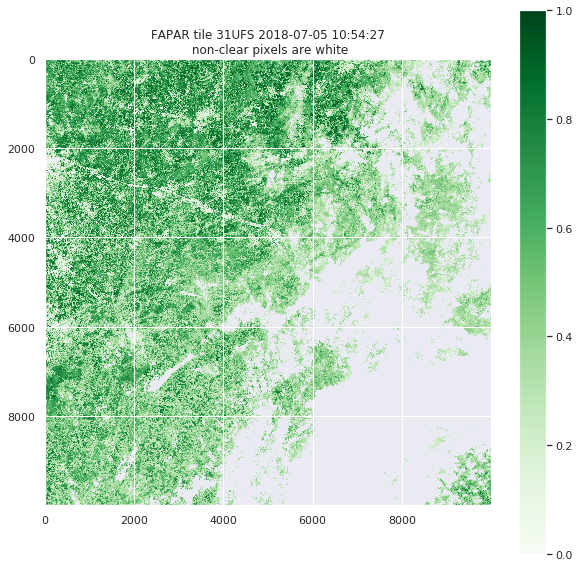

In [15]:
#set the seaborn plotting environment
sns.set()

#Take a subset, change these values if necessary
sub = np.array([0, 10000])

#Set NoData --> NaN, convert DN --> PV: for now use hard coded value
fapar_sub = d_fapar[sub[0]:sub[1],sub[0]:sub[1]]

fapar_sub[fapar_sub == 255] = -1
fapar_sub = fapar_sub * 0.005
fapar_sub[fapar_sub > 1.] = np.nan
print(np.nanmin(fapar_sub), np.nanmax(fapar_sub))

#create map plots for the RED and NIR and resulting NDVI, use subplots
mplot.figure(figsize=(10,10))
mplot.subplot(111) # we only want to plot one subplot

#show the FAPAR values
mplot.imshow(fapar_sub, cmap='Greens', vmin=0., vmax=1.0)
mplot.colorbar()

#there are many colormaps that you can use. See here: https://matplotlib.org/examples/color/colormaps_reference.html
mplot.title('FAPAR tile ' + FAPARFiles[2][4] + ' ' + FAPARFiles[2][2] + '\n non-clear pixels are white')

Now, let's do some processing. 
1. we will look for the raw 10 m Sentinel-2 bands 
2. then we load the RED (B03) and NIR (B08) bands to calculate the NDVI
3. and we show the results

In [16]:
#settings: product name, start and end date, and RoI
productName = 'CGS_S2_RADIOMETRY_10M' 
startDate = dt.date(2018,5,6)
endDate = dt.date(2018,5,7)
minLatitude = 51 
maxLatitude = 52
minLongitude = 4 
maxLongitude = 5

#catalog client request
listOfProducts = cat.get_products (productName, 
                            fileformat='GEOTIFF', 
                            startdate=startDate, 
                            enddate=endDate, 
                            min_lon=minLongitude, 
                            max_lon=maxLongitude, 
                            min_lat=minLatitude, 
                            max_lat=maxLatitude)

nbands = 0
productList=[]

#append to the product list
for p in listOfProducts:

    productelements=re.split("_",str(p))  
    nbands=nbands + len(p.bands())
    
    for b in p.bands():
        productdetails=[]
        productdetails.append(productelements[2])  # 0 product name 
        productdetails.append(productelements[3])  # 1 resolution
        productdetails.append(productelements[-1]) # 2 datetime
        productdetails.append(p.file(b)[5:]) # 3 filepath
       
        folders=re.split('/',p.file(b)[5:]) #this contains all subsequent folders + the actual filename
        filepath='/'
        for s in range(1,len(folders)-1):
            filepath = filepath + folders[s] + '/'
        productdetails.append(filepath) # 4 folder - we'll use this later, e.g. to retrieve the metadata file
        items=re.split('_',folders[-1:][0])
        productdetails.append(items[2]) # 5 UTM tile id
        productdetails.append(items[3]) # 6 file content
        productList.append(productdetails)

print ('Tile  Date       Time     Res Product')
print ('----- ---------- -------- --- -------')
for p in productList:
    print (p[5], p[2], p[1], p[0], p[6])

Tile  Date       Time     Res Product
----- ---------- -------- --- -------
31UFS 2018-05-06 10:54:23 10M RADIOMETRY TOC-B03
31UFS 2018-05-06 10:54:23 10M RADIOMETRY TOC-B04
31UFS 2018-05-06 10:54:23 10M RADIOMETRY TOC-B08
31UFS 2018-05-06 10:54:23 10M RADIOMETRY SHADOWMASK
31UFS 2018-05-06 10:54:23 10M RADIOMETRY TOC-B02
31UFS 2018-05-06 10:54:23 10M RADIOMETRY CLOUDMASK
31UET 2018-05-06 10:54:23 10M RADIOMETRY TOC-B04
31UET 2018-05-06 10:54:23 10M RADIOMETRY TOC-B02
31UET 2018-05-06 10:54:23 10M RADIOMETRY SHADOWMASK
31UET 2018-05-06 10:54:23 10M RADIOMETRY TOC-B08
31UET 2018-05-06 10:54:23 10M RADIOMETRY CLOUDMASK
31UET 2018-05-06 10:54:23 10M RADIOMETRY TOC-B03
31UES 2018-05-06 10:54:23 10M RADIOMETRY TOC-B04
31UES 2018-05-06 10:54:23 10M RADIOMETRY CLOUDMASK
31UES 2018-05-06 10:54:23 10M RADIOMETRY SHADOWMASK
31UES 2018-05-06 10:54:23 10M RADIOMETRY TOC-B03
31UES 2018-05-06 10:54:23 10M RADIOMETRY TOC-B02
31UES 2018-05-06 10:54:23 10M RADIOMETRY TOC-B08
31UFT 2018-05-06 10:54:23 1

All these files are stored in folders, and there is some more interesting data there as well.
* an XML file that contains the metadata
* a few quicklook files
* cloud and cloud shadow masks at different resolutions
* the scene classification file at 20 m resolution
* the AOT data

To illustrate this, let's see what is in the first folder

In [17]:
print(productList[0][4])
flist = os.listdir(productList[0][4])

for f in flist:
    print (f)
print (str(len(flist))+ " files found")

/data/MTDA/CGS_S2/CGS_S2_RADIOMETRY/2018/05/06/S2B_20180506T105029Z_31UFS_CGS_V102_000/S2B_20180506T105029Z_31UFS_TOC_V102/
S2B_20180506T105029Z_31UFS_TOC-B07_20M_V102.tif
S2B_20180506T105029Z_31UFS_CLOUDMASK_10M_V102.tif
S2B_20180506T105029Z_31UFS_AOT_60M_V102.tif
S2B_20180506T105029Z_31UFS_CLOUDMASK_20M_V102.tif
S2B_20180506T105029Z_31UFS_TOC-B08_10M_V102.tif
S2B_20180506T105029Z_31UFS_SCENECLASSIFICATION_20M_V102.tif
S2B_20180506T105029Z_31UFS_TOC-B02_10M_V102.tif
S2B_20180506T105029Z_31UFS_TOC-B06_20M_V102.tif
S2B_20180506T105029Z_31UFS_SHADOWMASK_20M_V102.tif
S2B_20180506T105029Z_31UFS_SHADOWMASK_10M_V102.tif
S2B_20180506T105029Z_31UFS_TOC_V102_QL.tif
S2B_20180506T105029Z_31UFS_TOC-B11_20M_V102.tif
S2B_20180506T105029Z_31UFS_TOC-B8A_20M_V102.tif
S2B_20180506T105029Z_31UFS_CLOUDMASK_60M_V102.tif
S2B_20180506T105029Z_31UFS_TOC_V102_WM_QL.tif
S2B_20180506T105029Z_31UFS_TOC-B01_60M_V102.tif
S2B_20180506T105029Z_31UFS_TOC-B12_20M_V102.tif
S2B_20180506T105029Z_31UFS_TOC-B05_20M_V102.tif

The metadata is in the xml file. Let's see if we can get out relevant information

In [18]:
xmlfile=list(filter(lambda f: "xml" in f,flist))
print (xmlfile[0])
tree = ET.parse(productList[0][4] + xmlfile[0])
root = tree.getroot()
print (root[11][0][14][0].text)  #print out the cloud cover %
#I looked this up; doesn't seem to be a good idea to do this as the xml file may be structured differently

S2B_20180506T105029Z_31UFS_TOC_V102.xml
0.650


Let's find the information in a less error-prone way: we are looking for the cloud cover percentage. In many cases, scenes with too much cloud cover are useless for practical data processing. Furthermore, we mask out the clouds in the FAPAR, FCOVER, LAI and NDVI products

In [19]:
for n in root.iter('{http://www.isotc211.org/2005/gmd}cloudCoverPercentage'):
    for c in n.findall('{http://www.isotc211.org/2005/gco}Real'):
        Cloudcover = c.text
Cloudcover       

'0.650'

In [20]:
Bands=[]
for n in root.iter('{http://www.isotc211.org/2005/gmd}MD_Band'):
    Bandinfo=[]
    for c in n.iter('{http://www.isotc211.org/2005/gco}MemberName'):
        l=[]
        for t in c.iter('{http://www.isotc211.org/2005/gco}CharacterString'):
            l.append(t.text) # O: identification string
        Bandinfo.append(l[0])
    for c in n.iter('{http://www.isotc211.org/2005/gmd}minValue'):
        for t in c.findall('{http://www.isotc211.org/2005/gco}Real'):
            Bandinfo.append(t.text) #1: min grey value
    for c in n.iter('{http://www.isotc211.org/2005/gmd}maxValue'):
        for t in c.findall('{http://www.isotc211.org/2005/gco}Real'):
            Bandinfo.append(t.text) #2: max grey value
    for c in n.iter('{http://www.isotc211.org/2005/gmd}bitsPerValue'):
        for t in c.findall('{http://www.isotc211.org/2005/gco}Integer'):
            Bandinfo.append(t.text) #3: bits per grey value (8 - 256 values, 16 - 65536 values) 
    for c in n.iter('{http://www.isotc211.org/2005/gmd}scaleFactor'):
        for t in c.findall('{http://www.isotc211.org/2005/gco}Real'):
            Bandinfo.append(t.text) #4: scale factor: how to relate the grey value to the actual value
    for c in n.iter('{http://www.isotc211.org/2005/gmd}offset'):
        for t in c.findall('{http://www.isotc211.org/2005/gco}Real'):
            Bandinfo.append(t.text) #5: offset value to add to the actual value   
    Bands.append(Bandinfo)
Bands    

[['S2B_20180506T105029Z_31UFS_TOC-B01_60M_V000',
  '-10000',
  '10000',
  '16',
  '0.000100000000000',
  '0.000000000000000'],
 ['S2B_20180506T105029Z_31UFS_TOC-B02_10M_V000',
  '-10000',
  '10000',
  '16',
  '0.000100000000000',
  '0.000000000000000'],
 ['S2B_20180506T105029Z_31UFS_TOC-B03_10M_V000',
  '-10000',
  '10000',
  '16',
  '0.000100000000000',
  '0.000000000000000'],
 ['S2B_20180506T105029Z_31UFS_TOC-B04_10M_V000',
  '-10000',
  '10000',
  '16',
  '0.000100000000000',
  '0.000000000000000'],
 ['S2B_20180506T105029Z_31UFS_TOC-B05_20M_V000',
  '-10000',
  '10000',
  '16',
  '0.000100000000000',
  '0.000000000000000'],
 ['S2B_20180506T105029Z_31UFS_TOC-B06_20M_V000',
  '-10000',
  '10000',
  '16',
  '0.000100000000000',
  '0.000000000000000'],
 ['S2B_20180506T105029Z_31UFS_TOC-B07_20M_V000',
  '-10000',
  '10000',
  '16',
  '0.000100000000000',
  '0.000000000000000'],
 ['S2B_20180506T105029Z_31UFS_TOC-B08_10M_V000',
  '-10000',
  '10000',
  '16',
  '0.000100000000000',
  '0.000

It would be a good idea now to couple the lists in <b>Bands</b> and <b>productList</b>, so that all information is collected together. I will let you figure this out by yourself


Let's do some processing on the data. We'll derive the NDVI index from the Red and IR bands.

In [21]:
for p in productList:
    if p[5]=='31UES': #let's just look at this tile
        if p[6] == 'TOC-B04': #red
            f_red = p[3]   
        if p[6] == 'TOC-B08': #near-infrared
            f_nir = p[3]
            
#read the files with rasterio 
with rasterio.open(f_red, 'r') as data:
    d_red = data.read(1).astype(float)
      
with rasterio.open(f_nir, 'r') as data:
    d_nir = data.read(1).astype(float)

During the atmospheric correction, some pixel values may become nonsensical (e.g. negative values). We'll take care of that. Furthermore, we'll convert the greyvalues into physical values, by applying the scale factor (which we found in the xml file) (and we should also apply the offset, but it's zero. So we'll skip that one)

In [22]:
noval = np.where((d_red == 32767) | (d_red < 0) | (d_nir == 32767) | (d_nir < 0))    
d_red[noval] = np.nan
d_nir[noval] = np.nan

#apply the scaling factor
d_red = d_red * 0.0001 
d_nir = d_nir * 0.0001

#compute the NDVI from RED and NIR
d_ndvi = (d_red - d_nir) / (d_red + d_nir)

Now, we'll show the original data and the NDVI derived from it. NDVI has values in the [-1,1] interval

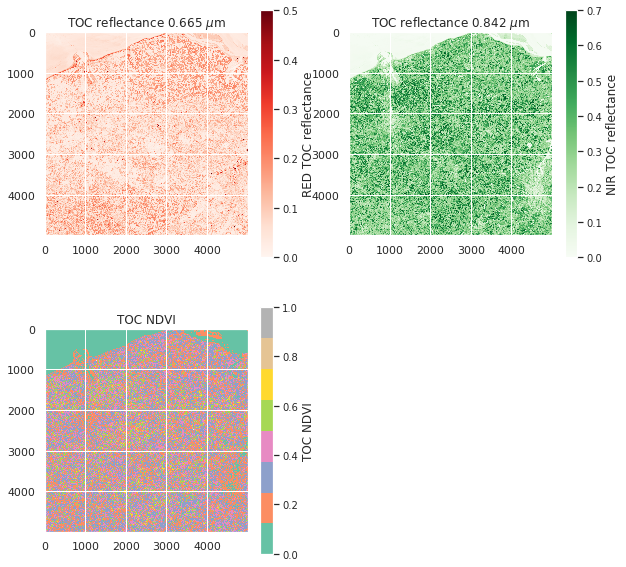

In [23]:
#take a subset, in this case the upper left quadrant
sub = np.array([500, 5500])

#make map plots for the RED and NIR and resulting NDVI, use subplots
mplot.figure(figsize=(10,10))
mplot.subplot(221)

#TOC reflectances
mplot.imshow(d_red[sub[0]:sub[1],sub[0]:sub[1]], cmap='Reds', vmin=0., vmax=0.5)
mplot.title('TOC reflectance 0.665 $\mu$m')

cb = mplot.colorbar(aspect=20)  
cb.ax.set_ylabel('RED TOC reflectance')
cb.ax.tick_params(labelsize=10)

mplot.subplot(222)
mplot.imshow(d_nir[sub[0]:sub[1],sub[0]:sub[1]], cmap='Greens', vmin=0., vmax=0.7)
mplot.title('TOC reflectance 0.842 $\mu$m')
cb = mplot.colorbar(aspect=20)  
cb.ax.set_ylabel('NIR TOC reflectance')
cb.ax.tick_params(labelsize=10)

#TOC NDVI
mplot.subplot(223)
mplot.imshow(d_nir[sub[0]:sub[1],sub[0]:sub[1]], cmap='Set2', vmin=0., vmax=1.0)
mplot.title('TOC NDVI')

#same as for the TOC reflectance colorbar, but now for TOC NDVI
cb = mplot.colorbar(aspect=20)  
cb.ax.set_ylabel('TOC NDVI')
cb.ax.tick_params(labelsize=10)

So, we're at the end of this introduction. You now know where to find the data, and have seen so